In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import arff
import time
from sklearn.metrics import r2_score
from past.utils import old_div
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv
from sklearn.model_selection import train_test_split

In [10]:
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *

In [2]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))
df_train, df_test = df_long.iloc[:315,:], df_short
y_train, date_train = df_train.pop('bp').values, df_train.pop('Date').values
y_test, date_test = df_test.pop('bp').values, df_test.pop('Date')

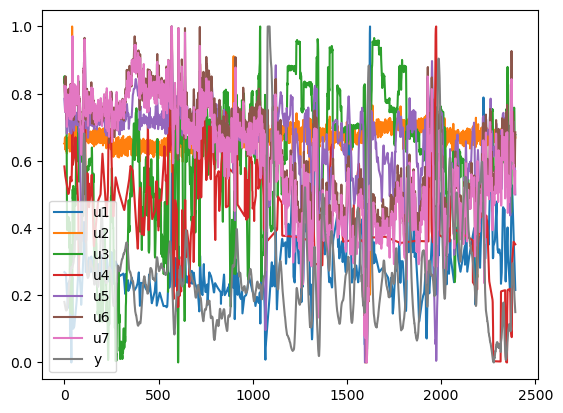

In [11]:
# Debutanizer Column data set
df = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Debutanizer Column\debutanizer_data.txt', 
                 delimiter='\s+', header=None, skiprows=3, names=['u1','u2','u3','u4','u5','u6','u7','y'],)
df.plot() # already normalized data
y_column = df.pop('y').values
X_column = df.values
split = 2000
X_train, X_test = X_column[:split,:], X_column[split:,:]
y_train, y_test = y_column[:split], y_column[split:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [18]:
# Melt index prediction
MI1 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M1.txt',header=0,index_col=0,sep='\t')
MI2 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M2.txt',header=0,sep='\t')
MI3 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M3.txt',header=0,sep='\t')
MI1 = MI1.reset_index(drop=True)
raw_data = pd.concat([MI1.iloc[:,:12], MI2.iloc[:,:8], MI3], axis=1)
raw_data.drop(314, inplace=True)
target = raw_data.pop(raw_data.columns[-1]).values
X_train, X_test, y_train, y_test = train_test_split(raw_data.values[:,12:], target, train_size=249, shuffle=False)
# Already in the range of 0~1 and include a constant column
print(X_train.shape, X_test.shape)

(249, 17) (81, 17)


In [5]:
# Gas Turbine CO and NOx emission data set
df_gas = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Gas Turbine CO and NOx Emission Data Set\gt_2012.csv')
resample_fre = round(df_gas.shape[0]/365)
df_gas_day = df_gas[::20].iloc[:365,:].reset_index(drop=True)
y_NO = df_gas_day.pop('NOX').values
y_CO = df_gas_day.pop('CO').values
X_gas = df_gas_day.values
split = 300
X_train, X_test = X_gas[:split,:], X_gas[split:,:]
y_train, y_test = y_CO[:split], y_CO[split:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [4]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    chol_a = np.linalg.cholesky(a)
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [4]:
num = 12
X_train, X_test = df_train.iloc[:,:num], df_test.iloc[:,:num]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [60]:
# System Identification for state space model.
# ξ_t+1 = Aξ_t + w_t
# y_t = Cx_t + Hξ_t + v_t
sys_id = system_identification(y_train, X_train, 'MOESP', SS_orders=[2,10],IC='AIC')

The suggested order is: n= 2
Kalman filter cannot be calculated


In [59]:
sys_id.K

matrix([[-0.04729738],
        [ 0.00066266]])

In [33]:
# Sulfur recovery unit dataset
dataset = arff.load(open('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Sulfur Recovery Unit\Sulfur.arff'))
data = pd.DataFrame(dataset['data'])
features, target  = data.iloc[:, :5], data.iloc[:, 5:]
features_lagged = pd.concat([features, 
                             features.shift(5),
                             features.shift(7),
                             features.shift(9)], axis=1)
features_lagged, target = features_lagged.iloc[9:,:], target.iloc[9:,:]
X_sulfur, y_sulfur = features_lagged.values, target.iloc[:,1].values
X_train, X_test = X_sulfur[:7000,:], X_sulfur[7000:,:]
y_train, y_test = y_sulfur[:7000], y_sulfur[7000:]

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

In [5]:
class Parameters:
    def __init__(self, init_theta, init_P, A, H, Q, C, R) -> None:
        self.theta0 = init_theta
        self.P0 = init_P
        self.A = A
        self.H = H
        self.Q = Q
        self.C = C
        self.R = R

class KFResults:
    def __init__(self, pred, prediction_cov, filter,
     filter_cov, prior, prior_cov, K, A, H, C) -> None:
        self.pred = pred
        self.prediction_cov = prediction_cov
        self.filter = filter
        self.filter_cov = filter_cov
        self.prior = prior
        self.prior_cov = prior_cov
        self.kalman_gain = K
        self.A = A
        self.H = H
        self.C = C

class KSResults:
    def __init__(self, smooth, smooth_cov, smooth_lagcov) -> None:
        self.smooth = smooth
        self.smooth_cov = smooth_cov
        self.smooth_lagcov = smooth_lagcov

In [6]:
def KalmanFilter(X, y, parameters, k_states):
    
    # Matrix dimension
    nobs = X.shape[0] 

    # Allocate memory for all kinds of process variables
    filter = np.zeros((k_states, nobs))
    filter_cov = np.zeros((k_states, k_states, nobs))
    prior = np.zeros((k_states, nobs))
    prior_cov = np.zeros((k_states, k_states, nobs))
    pred = np.zeros((1, nobs))
    pred_v = np.zeros((1, 1, nobs))
    A, H, C = parameters.A, parameters.H, parameters.C

    # Initialization - the first iteration
    mu0 = parameters.theta0 # Initial guess of the states
    V0 = parameters.P0      # Uncertainty about the initial guess
    x = X[0,:,None]
    K = V0 @ H.T @ inv(H @ V0 @ H.T + parameters.R)
    filter[:,0,None] = mu0 + K @ (y[0] - H @ mu0 - C @ x)
    filter_cov[:,:,0] = (np.eye(k_states) - K @ H) @ V0
    prior[:,0,None] = A @ filter[:,0,None]
    prior_cov[:,:,0] = A @ filter_cov[:,:,0] @ A.T + parameters.Q
    pred[:,0] = H @ prior[:,0,None] + C @ x
    pred_v[:,:,0] = H @ prior_cov[:,:,0] @ H.T + parameters.R

    for t in range(1, nobs):
        x = X[t,:,None]

        # Kalman gain and correction based on the observation
        K = prior_cov[:,:,t-1] @ H.T @ inv(H @ prior_cov[:,:,t-1] @ H.T + parameters.R)
        filter[:,t,None] = prior[:,t-1,None] + K @ (y[t] - H @ prior[:,t-1,None] - C @ x)
        filter_cov[:,:,t] = (np.eye(k_states) - K @ H) @ prior_cov[:,:,t-1] 

        # one step ahead prediction
        prior[:,t,None] = A @ filter[:,t,None] 
        prior_cov[:,:,t] = A @ filter_cov[:,:,t] @ A.T + parameters.Q
        pred[:,t] = H @ prior[:,t] + C @ x
        pred_v[:,:,t] = H @ prior_cov[:,:,t] @ H.T + parameters.R

    
    KFresults = KFResults(pred.ravel(), pred_v.ravel(), filter, 
    filter_cov, prior, prior_cov, K, A, H, C)
    return KFresults

In [7]:
def KalmanFilterPred(X, y, KFResults, Q, R, k_states):

    ytrhat = KFResults.pred
    ytehat_on = np.zeros(X_test.shape[0])
    ytehat_off = np.zeros(X_test.shape[0])
    
    A = KFResults.A
    H = KFResults.H
    C = KFResults.C
    # k_states = X.shape[1]

    prior = A @ KFResults.filter[:,-1,None]
    prior_cov = A @ KFResults.filter_cov[:,:,-1] @ A.T + Q
    ytehat_on[0] = H @ prior + C @ X[0,:,None]
    pred_v = H @ prior_cov @ H.T + R
    K = prior_cov @ H.T @ inv(pred_v)
    posterior = prior + K @ (y[0] - H @ prior - C @ X[0,:,None])
    posterior_cov = (np.eye(k_states) - K @ H) @ prior_cov

    for t in range(1, X.shape[0]):
        prior = A @ posterior 
        prior_cov = A @ posterior_cov @ A.T + Q
        ytehat_on[t] = H @ prior + C @ X[t,:,None]
        pred_v = H @ prior_cov @ H.T + R
        K = prior_cov @ H.T @ inv(pred_v)
        posterior = prior + K @ (y[t] - H @ prior - C @ X[t,:,None])
        posterior_cov = (np.eye(k_states) - K @ H) @ prior_cov

    prior_off = KFResults.filter[:,-1,None]
    for t in range(X.shape[0]):
        prior_off = A @ prior_off 
        ytehat_off[t] = C @ X[t,:,None] + H @ prior_off 

    return ytrhat, ytehat_on, ytehat_off
    

In [8]:
def KalmanSmoother(X, KFResults):
    mu = KFResults.filter     # filtered states
    V = KFResults.filter_cov  # filtered state cov
    P = KFResults.prior_cov   # prior state cov
    A = KFResults.A
    
    # Matrix dimension
    k_states = P.shape[0]
    nobs = P.shape[2]

    # Allocate memory for all kinds of process variables
    J = np.zeros((k_states, k_states, nobs-1)) # Smoother gain
    smooth = np.zeros((k_states, nobs))
    smooth_cov = np.zeros((k_states, k_states, nobs))
    smooth_lagcov = np.zeros((k_states, k_states, nobs-1))

    smooth[:,-1] = mu[:,-1]
    smooth_cov[:,:,-1] = V[:,:,-1]

    for t in range(nobs-2, -1, -1):
        # x = X[t,:,None]
        J[:,:,t] = V[:,:,t] @ A.T @ inv(P[:,:,t])
        smooth[:,t,None] = mu[:,t,None] + J[:,:,t] @ (smooth[:,t+1,None] - A @ mu[:,t,None])
        smooth_cov[:,:,t] = (V[:,:,t] + J[:,:,t] \
                                 @ (smooth_cov[:,:,t+1] - P[:,:,t]) @ J[:,:,t].T)
        
    
    for t in range(nobs-2, -1, -1):
        smooth_lagcov[:,:,t] = J[:,:,t] @ smooth_cov[:,:,t+1]
    
    return KSResults(smooth, smooth_cov, smooth_lagcov)
    

In [9]:
def EMalgorithm(X, y, k, params, k_states):

    # Initialize state and state_cov
    nobs = X.shape[0]
    d = X.shape[1]
    Likelihood = []

    for iter in range(k):

        # Expectation step 1 -> Kalman Filter
        KFresults = KalmanFilter(X, y, params, k_states)

        # Expextation step 2 -> Kalman Smoother
        KSResults = KalmanSmoother(X, KFResults=KFresults)

        # Maximization step 
        smooth = KSResults.smooth
        smooth_P = KSResults.smooth_cov
        smooth_P_lag = KSResults.smooth_lagcov

        # Intermediate varaibles
        D = np.zeros((k_states,k_states))
        E = np.zeros((k_states,k_states))
        F = np.zeros((k_states,k_states))
        G = np.zeros((1,d))
        I = np.zeros((d,k_states))
        J = np.zeros((1,k_states))
        K = np.zeros((d,d))

        for t in range(1, nobs): # 1~314, length of (n-1)
            sn = smooth[:,t,None]     # t = n
            sn_1 = smooth[:,t-1,None] # t = n-1

            D += smooth_P[:,:,t] + sn @ sn.T         #  E[ξ_n @ ξ_n.T]
            E += smooth_P_lag[:,:,t-1] + sn @ sn_1.T #  E[ξ_n @ ξ_n-1.T]
            F += smooth_P[:,:,t-1] + sn_1 @ sn_1.T   #  E[ξ_n-1 @ ξ_n-1.T]
        
        for t in range(nobs):
            sn = smooth[:,t,None]
            x = X[t,:,None]
            G += y[t] * x.T  # y[n] @ x_n.T
            J += y[t] * sn.T # y[n] @ E[ξ_n.T]    
            I += x @ sn.T    # x[n] @ E[ξ_n.T] 
            K += x @ x.T     # x[n] @ x[n].T 

        # print(check_symmetric(F))

        # Updated parameters
        init_theta = smooth[:,0,None]
        init_P = smooth_P[:,:,0]
        new_A = E @ inv(F)
        new_Q = (D - E @ new_A.T - new_A @ E.T + new_A @ F @ new_A.T) / (nobs-1)
        D += init_theta @ init_theta.T
        new_C = (G - J @ inv(D) @ I.T) @ inv(K - I @ inv(D) @ I.T)
        new_H = (J - new_C @ I) @ inv(D)
        new_R = (y[None,:] @ y[:,None] - y[None,:] @ X @ new_C.T - y[None,:] @ smooth.T @ new_H.T \
                 - new_C @ X.T @ y[:,None] + new_C @ X.T @ X @ new_C.T + new_C @ X.T @ smooth.T @ new_H.T \
                 - new_H @ smooth @ y[:,None] + new_H @ smooth @ X @ new_C.T + new_H @ D @ new_H.T) / nobs  

        params = Parameters(init_theta, init_P, new_A, new_H, new_Q, new_C, new_R)

        # loglikelihood calculation
        sigma, mu = KFresults.filter_cov[:,:,0], KFresults.filter[:,0,None]
        P_0n, s_0n = KSResults.smooth_cov[:,:,0], KSResults.smooth[:,0,None]
        # sigma and mu part
        L1 = -0.5 * np.log(np.linalg.det(sigma)) +\
            -0.5 * np.trace(inv(sigma) @ (P_0n + (s_0n - mu) @ (s_0n - mu).T)) 
        
        # Q part
        L2 = -0.5 * (nobs - 1) * np.log(np.linalg.det(new_Q)) +\
            -0.5 * np.trace(inv(new_Q) @ ((D - init_theta @ init_theta.T) - E @ new_A.T - new_A @ E.T + new_A @ F @ new_A.T))
        
        # R part
        L3 = -0.5 * nobs * np.log(np.linalg.det(new_R)) +\
            -0.5 * np.trace(inv(new_R) @ (new_R * nobs))
        L = L1 + L2 + L3
        Likelihood.append(L)

        print('------- Loglikelihood of No. %d iteration -------' % (iter+1))
        print('Total: %.2f, Init: %.2f, Q: %.2f, R: %.2f\n' % (L, L1, L2, L3))

    return params, Likelihood 

------- Loglikelihood of No. 1 iteration -------
Total: 41827.90, Init: -45.87, Q: 21471.62, R: 20402.16

------- Loglikelihood of No. 2 iteration -------
Total: 43256.06, Init: -28.94, Q: 21235.28, R: 22049.72

------- Loglikelihood of No. 3 iteration -------
Total: 43492.87, Init: -22.56, Q: 20848.94, R: 22666.50

------- Loglikelihood of No. 4 iteration -------
Total: 43512.14, Init: -15.83, Q: 20403.80, R: 23124.17

------- Loglikelihood of No. 5 iteration -------
Total: 43479.15, Init: -11.12, Q: 19928.06, R: 23562.21

------- Loglikelihood of No. 6 iteration -------
Total: 43435.77, Init: -7.95, Q: 19430.67, R: 24013.05

------- Loglikelihood of No. 7 iteration -------
Total: 43402.81, Init: -5.80, Q: 18913.83, R: 24494.77

------- Loglikelihood of No. 8 iteration -------
Total: 43430.81, Init: -3.67, Q: 18384.28, R: 25050.20

------- Loglikelihood of No. 9 iteration -------
Total: 43498.74, Init: -1.63, Q: 17833.30, R: 25667.07

------- Loglikelihood of No. 10 iteration -------


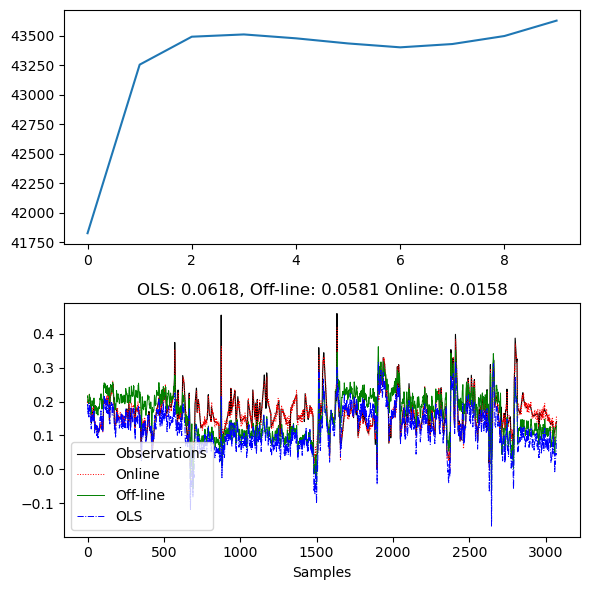

In [48]:
np.random.seed(21) # 21 - 0.0502,  74-Latter drifted
k_states = 2
d = X_train.shape[1] 
res = sm.OLS(y_train, X_train).fit()
ytehat_ols = res.predict(X_test)
params = Parameters(
    init_theta = np.zeros((k_states, 1)),
    # init_theta = np.random.rand(k_states, 1),
    init_P = np.diag([100]*k_states), 
    A = np.diag([0.3]*k_states),
    H = np.random.rand(1, k_states),
    Q = np.diag([0.01]*k_states),
    C = np.random.rand(1, d),
    # C = res.params[None,:],
    R = np.array([[0.01]]))
start_time = time.time()
results, likelihood = EMalgorithm(X_train, y_train, 10, params, k_states)
end_time = time.time()
print("Running time : %.4f" % (end_time-start_time))

KF_em = KalmanFilter(X_train, y_train, results, k_states)
ytrhat, ytehat_em, ytehat_off = KalmanFilterPred(X_test, y_test, KF_em, results.Q, results.R, k_states)

print('OLS rmse %.4f, OLS mae %.4f' % (rmse(y_test, ytehat_ols),mae(y_test, ytehat_ols)))
fig, axes = plt.subplots(2,1,figsize = [6,6])
axes[0].plot(likelihood)

# axes[1].plot(y_train, label='Observations')
# axes[1].plot(ytrhat, label='EM')
# axes[1].set_title('RMSE: %.4f' % rmse(y_train, ytrhat))
# axes[1].legend()

axes[1].plot(y_test,'k', linewidth=0.8, label='Observations')
axes[1].plot(ytehat_em, 'r:', linewidth=0.7, label='Online')
axes[1].plot(ytehat_off, 'g', linewidth=0.7, label='Off-line')
axes[1].plot(ytehat_ols, 'b-.', linewidth=0.7, label='OLS')
axes[1].set_title('OLS: %.4f, Off-line: %.4f Online: %.4f' % (rmse(y_test, ytehat_ols),rmse(y_test, ytehat_off),rmse(y_test, ytehat_em)))
axes[1].set_xlabel('Samples')
plt.tight_layout()
plt.legend()

data = {'Observations': y_test, 'LDS': ytehat_em, 'LDS Off': ytehat_off}
df_result = pd.DataFrame(data)
# relative_path = os.path.join(os.getcwd(), 'Variables', 'Debutanizer-MV3.csv')
# relative_path = os.path.join(os.getcwd(), 'Variables', 'MeltIndex-MV3.csv')
# relative_path = os.path.join(os.getcwd(), 'Variables', 'Sulfur-MV3.csv')
# df_result.to_csv(relative_path, index=False)

In [49]:
print('EM train rmse %.4f, test rmse %.4f' % (rmse(y_train, ytrhat),rmse(y_test, ytehat_em)))
print('EM train mae %.4f, test mae %.4f' % (mae(y_train, ytrhat),mae(y_test, ytehat_em)))
print('Off rmse %.4f, Off mae %.4f' % (rmse(y_test, ytehat_off),mae(y_test, ytehat_off)))

EM train rmse 0.0100, test rmse 0.0158
EM train mae 0.0055, test mae 0.0108
Off rmse 0.0581, Off mae 0.0509


In [58]:
print(results.Q, '\nC',results.C)


[[0.01904435 0.03657404]
 [0.03657404 0.07513176]] 
C [[ 2.39630779e-01  1.14271378e-02 -1.19607646e-04 -1.77324906e-02
   3.40042409e-02 -1.36658499e-03  1.91471096e-02  3.46291828e-02]]


In [59]:
print(results.R, check_symmetric(results.Q))
print(results.H)

[[2.10697822e-05]] True
[[0.02740207 0.05552969]]


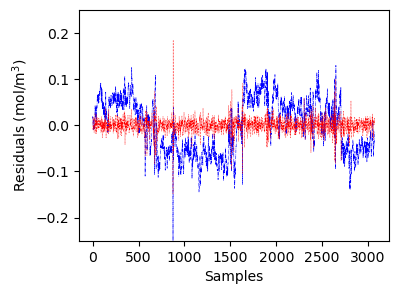

In [50]:
fig, axes = plt.subplots(figsize=(4,3))
# axes.plot(y_test, 'k-', linewidth=0.7, label='Measurements')
axes.plot(ytehat_off-y_test, 'b-.', linewidth=0.4, label='Offline prediction')
axes.plot(ytehat_em-y_test, 'r:', linewidth=0.4, label='Online prediction')
# axes.set_ylabel('Butane content (%)')
# axes.set_ylabel('Melt index (g/10 min)')
axes.set_ylabel(r'Residuals (mol/m$^3$)')
axes.set_xlabel('Samples')
# axes.set_ylim(-0.2,0.8)
# axes.set_ylim(-0.03,0.28)
axes.set_ylim(-0.25,0.25)
# axes.legend()
relative_path = os.path.join(os.getcwd(), 'Figures', 'SulfurM3.png')
plt.savefig(relative_path, dpi=600, bbox_inches='tight')